In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight


In [2]:
df = pd.read_csv('prep_data.csv')

In [4]:
df.shape

(253506, 58)

# Make train data

Create train data out of those cases where last funding round is known. For them target variable - deal stage - can be explicitly identified. 

In [5]:
def get_train_data(data):
    
    data = data[data.investment_type > 0] 
    data.reset_index(drop=True, inplace=True)
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=data.investment_type.map({
        1:'Seed', 
        2:'Series_A', 
        3:'Series_B', 
        4:'Growth'
    }).value_counts(dropna=False).index,
                     y=data.investment_type.value_counts(dropna=False),
                     palette='BuPu')
    plt.ylabel('Value counts', fontsize=12)
    plt.xlabel('Deal stage', fontsize=12)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig('demo.png', transparent=True)
    
    y = (data.investment_type - 1).values
    X = data.drop(['investment_type', 'company_name_x', 'domain'], axis=1)

    return X, y

Draw a plot of target variable distribution. 

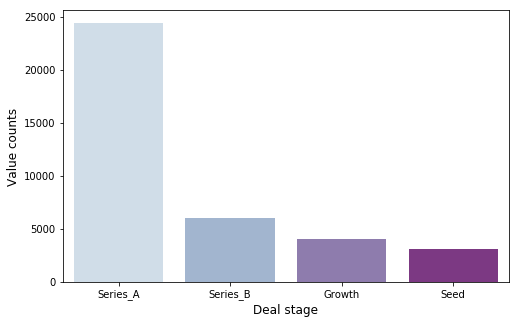

In [6]:
X, y = get_train_data(df)

In [7]:
X.shape

(37614, 55)

# Modelling

In [8]:
X.head()

,Client_Focus__c,employee_count,age,Main_Client_Sector__c,Business_Model__c,funding_rounds,funding_total_usd,raised_amount_usd,europe,eu,dach,nordics,western_europe,eastern_europe,southern_europe,north_america,asia,brics,baltics,cw_of_ind_states,lat_america,near_east,north_africa,ssh_africa,oceania,funding_ago,accomodation,automotive,chem-pharma,construction,education,energy,entertainment,fashion,finance,food,health-services,household,insurance,it,manufacturing,metalandmining,mining,ngo,other-services,professional-services,public-admin,real-estate,sector-agnostic,support-service,telecommunication,trade,transportation,travel,utilities
0,0,1,1.117043,0,0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.991102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,5.702943,0,0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.097878,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,7.118412,11,9,1.0,12500000.0,12500000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.007529,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,2.116359,0,0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.854209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2,4.117728,10,9,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.543463,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.1, 
                                                    stratify=y,
                                                    random_state=241)

In [10]:
from collections import Counter
Counter(y_train)

Counter({1.0: 21966, 2.0: 5438, 3.0: 3666, 0.0: 2782})

In [11]:
Counter(y_test)

Counter({2.0: 604, 1.0: 2441, 3.0: 408, 0.0: 309})

## Functions for diff transformations

In [12]:
nums =  [
    'age', 
    'funding_total_usd', 
    'funding_ago', 
    'funding_rounds',
    'raised_amount_usd'
]

cats = [
    'employee_count',
    'Main_Client_Sector__c',
    'Business_Model__c',
    'Client_Focus__c'
]        

In [13]:
#function to normalize the data
def scaling(df, std_scaler):
    df1 = df.copy()
    df1[std_scaler] = StandardScaler().fit_transform(df1[std_scaler])
    return df1

#function to log scale the data
def log_tranform(df, features):
    df1 = df.copy()
    df1 = df1.apply(lambda x: np.log(x+1) if x.name in features else x)
    return df1

In [14]:
from imblearn.under_sampling import TomekLinks
def tomek_transform(X, y):
    
    X_tr, y_tr = TomekLinks().fit_resample(X, y)
    X_tr = pd.DataFrame(X_tr, columns=X.columns.values)
    
    return X_tr, y_tr

In [15]:
def smote_transform(X, y):
    
    X_res, y_res = SMOTENC(categorical_features=[X.columns.get_loc(x) for x in X.columns if x not in nums]).fit_resample(X, y)
    X_res = pd.DataFrame(X_res, columns=X.columns.values)
    
    return X_res, y_res

In [16]:
from imblearn.under_sampling import RandomUnderSampler
def undersampling(X, y):
    
    X_tr, y_tr=RandomUnderSampler().fit_resample(X, y)
    X_tr = pd.DataFrame(X_tr, columns=X.columns.values)
    return X_tr, y_tr

In [17]:
from imblearn.under_sampling import EditedNearestNeighbours
def edited_neighbours(X, y, sampling_strategy='auto'):
    
    X_tr, y_tr=EditedNearestNeighbours(sampling_strategy=sampling_strategy).fit_resample(X, y)
    X_tr = pd.DataFrame(X_tr, columns=X.columns.values)
    
    return X_tr, y_tr

In [18]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
def ncr_transform(X, y, sampling_strategy='auto'):
    
    X_tr, y_tr = NeighbourhoodCleaningRule(sampling_strategy=sampling_strategy).fit_resample(X, y)
    X_tr = pd.DataFrame(X_tr, columns=X.columns.values)
    
    return X_tr, y_tr

## Functions for all models to be tested

In [19]:
def rf_model(X_train,y_train):
    
    params={'classifier__n_estimators':[200],
            'classifier__criterion':['gini','entropy'],
            'classifier__min_samples_leaf':[1,3,5]}

    pipe = Pipeline([
                ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))
                ])

    clf = GridSearchCV(pipe, params, cv = 5, scoring='f1_weighted')
    clf.fit(X_train, y_train)

    print('f1_weighted =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_

In [20]:
from imblearn.ensemble import BalancedRandomForestClassifier

def balancedrf_model(X_train, y_train):

    params={'classifier__n_estimators':[200],
            'classifier__criterion':['gini','entropy'],
            'classifier__min_samples_leaf':[3,5,7]}

    pipe = Pipeline([
                ('classifier', BalancedRandomForestClassifier())
                ])

    clf = GridSearchCV(pipe, params, cv = 5, scoring='f1_weighted')
    clf.fit(X_train,y_train)

    print('f1_weighted =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_

In [21]:
def cat_model(X_train, y_train):
    
    params = {
         'loss_function':['MultiClass'],
         #'depth': [4, 6, 8],
         #'l2_leaf_reg': [1,3,5],
         'iterations': [200]
         }
    cb = CatBoostClassifier(logging_level='Silent')
    cb_model = GridSearchCV(cb, params, cv = 5, scoring='f1_weighted')
    cb_model.fit(X_train, y_train, cat_features=[X_train.columns.get_loc(x) for x in X_train.columns if x not in nums])
    print('f1_weighted =', cb_model.best_score_)
    
    return cb_model.best_estimator_
    

In [22]:
def knn_model(X_train, y_train):

    X_train = scaling(X_train, nums)
        
    params = {'classifier__n_neighbors':[5], 
              'classifier__weights':['uniform', 'distance']}

    pipe = Pipeline([
                ('onehot', 
                 OneHotEncoder(categorical_features=[X_train.columns.get_loc(x) for x in X_train.columns if x in cats])),
                ('classifier', 
                 KNeighborsClassifier())
                ])

    clf = GridSearchCV(pipe, params, cv = 5, scoring='f1_weighted')
    clf.fit(X_train, y_train)

    print('f1_weighted =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_
    

In [23]:
def logistic_model(X_train,y_train):
    X_train = scaling(X_train,nums)
    
    params = {'classifier__C':[0.1, 1, 10],
              'classifier__solver':['liblinear','newton-cg','sag','saga', 'lbfgs']},

    pipe = Pipeline([
                ('onehot', 
                 OneHotEncoder(categorical_features=[X_train.columns.get_loc(x) for x in X_train.columns if x in cats])),
                ('classifier', 
                 LogisticRegression(penalty="l2", multi_class='auto', class_weight='balanced'))
                ])

    clf = GridSearchCV(pipe, params, cv = 3, scoring='f1_weighted')
    clf.fit(X_train, y_train)

    print('f1_weighted =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_
    

In [24]:
def XGB_model(X_train,y_train):
    
    params={},

    pipe = Pipeline([
                ('onehot', 
                 OneHotEncoder(categorical_features=[X_train.columns.get_loc(x) for x in X_train.columns if x in cats])),
                ('classifier', 
                 XGBClassifier(scale_pos_weight=compute_class_weight('balanced', np.unique(y_train), y_train)))
                ])
    #print(Counter(y_train))
    #print(compute_class_weight('balanced', np.unique(y_train), y_train))
    clf = GridSearchCV(pipe, params, cv = 5, scoring='f1_weighted')
    clf.fit(X_train, y_train)

    print('f1_weighted =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_
    

In [25]:
def ada_model(X_train,y_train):
    
    params={},

    pipe = Pipeline([
                ('onehot', OneHotEncoder(categorical_features=[X_train.columns.get_loc(x) for x in X_train.columns if x in cats])),
                ('classifier', AdaBoostClassifier())
                ])

    clf = GridSearchCV(pipe, params, cv = 5, scoring='f1_weighted')
    clf.fit(X_train,y_train)

    print('f1_weighted =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_
    

## Function to combine a model to be tested with possible transformations above

In [26]:
def test_model(model, transformation=None, smote=False, X=X_train, y=y_train, X_t=X_test, y_t=y_test):
    if transformation is None:
        X1, y1 = X, y
    else:
        X1, y1 = transformation(X, y)
    if smote is True:
        X1, y1 = smote_transform(X1, y1)
    clf = model(X1, y1)
    y_pred = clf.predict(X_t)
    
    print('Accuracy =', accuracy_score(y_t, y_pred))
    print('Balanced accuracy =', balanced_accuracy_score(y_t, y_pred))
    print('F1 score =', f1_score(y_t, y_pred, average='weighted'))
    
    mm_input = pd.DataFrame()
    mm_input['y'] = y_t
    mm_input['y_pred'] = y_pred

    edges = mm_input.groupby('y')['y_pred'].value_counts()
    m = pd.DataFrame(edges.unstack(level=-1))
    m = m.div(m.sum(axis=1), axis=0)
    a4_dims = (5, 5)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title('Mismatches (ALL)')
    sns.heatmap(m, annot=True,cmap='BuPu')
    plt.show()
    
#     try:
#         importances = clf.named_steps['classifier'].feature_importances_
#         indices = np.argsort(importances)[::-1]
#         for f in range(X1.shape[1]):
#             print(X1.columns.values[f], importances[indices[f]])
#     except:
#         print('Feature importance not availaible for {}'.format(model))

## Test simple (not weighted) models

In [27]:
import warnings
warnings.simplefilter('ignore')

f1_weighted = 0.7381897935322234
Accuracy = 0.7830940988835726
Balanced accuracy = 0.5396434529749511
F1 score = 0.7410007264696427


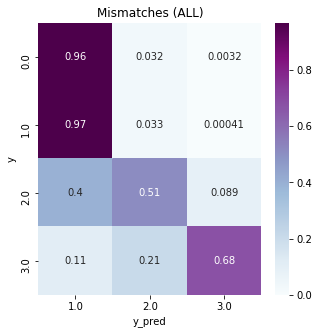

In [28]:
test_model(cat_model)

f1_weighted = 0.7268938540289285
Best params = {}
Accuracy = 0.7769803296119085
Balanced accuracy = 0.5361348696661016
F1 score = 0.7339969616008268


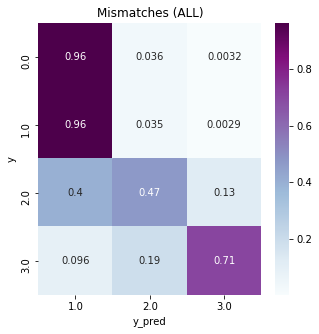

In [29]:
test_model(ada_model)

f1_weighted = 0.637170805617107
Best params = {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Accuracy = 0.25412014885699097
Balanced accuracy = 0.30833947493358393
F1 score = 0.2614132396174472


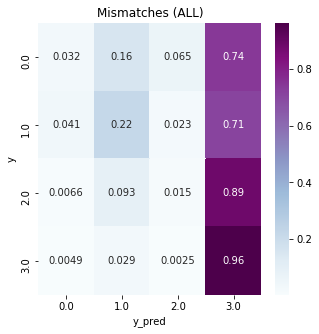

In [30]:
test_model(knn_model)

## Test weighted models

Random forest

f1_weighted = 0.7439592005334174
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
Accuracy = 0.7570441254651781
Balanced accuracy = 0.6064286485299186
F1 score = 0.7511143119223306


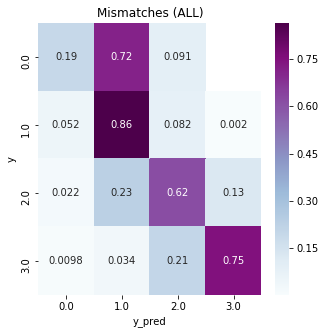

In [31]:
test_model(rf_model)

Balanced RF (randomly under-samples each boostrap sample to balance it)

f1_weighted = 0.622085941815194
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 200}
Accuracy = 0.5879851143009037
Balanced accuracy = 0.6412422883118876
F1 score = 0.6329003564915024


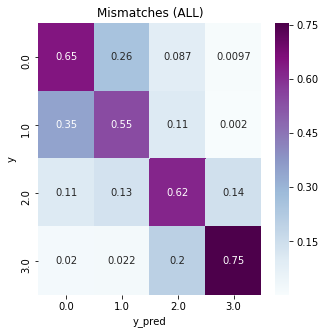

In [32]:
test_model(balancedrf_model)

XGBoost

f1_weighted = 0.7405469867501838
Best params = {}
Accuracy = 0.7886762360446571
Balanced accuracy = 0.5456515304492078
F1 score = 0.7456998771810572


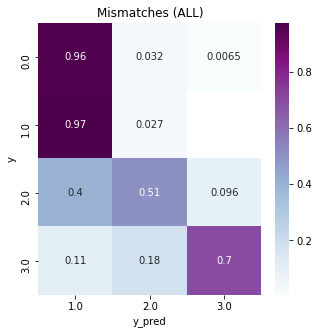

In [33]:
test_model(XGB_model)

Logistic regression

f1_weighted = 0.7120535753764616
Best params = {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Accuracy = 0.29372674109516217
Balanced accuracy = 0.31270910146114983
F1 score = 0.30341857734704386


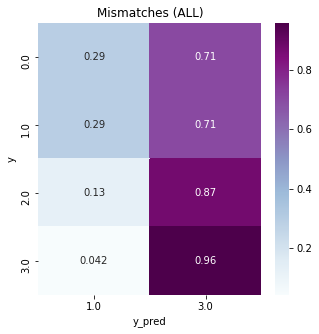

In [34]:
test_model(logistic_model)

## Balance data with SMOTE

f1_weighted = 0.8517664879515167
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Accuracy = 0.7259436469962786
Balanced accuracy = 0.5739654655374379
F1 score = 0.7233557041387241


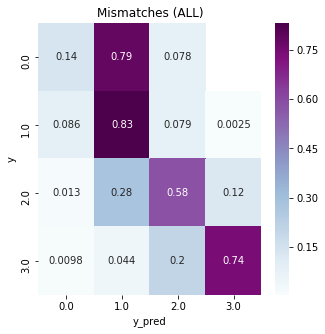

In [35]:
test_model(model=rf_model, smote=True)

f1_weighted = 0.7143492716699271
Best params = {}
Accuracy = 0.654173312068049
Balanced accuracy = 0.5914338005776613
F1 score = 0.6821720379269303


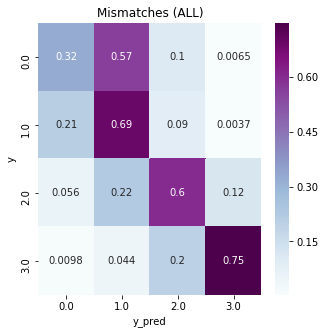

In [36]:
test_model(model=XGB_model, smote=True)

f1_weighted = 0.6414649514657866
Best params = {}
Accuracy = 0.6092503987240829
Balanced accuracy = 0.5659151745293449
F1 score = 0.6476430030625441


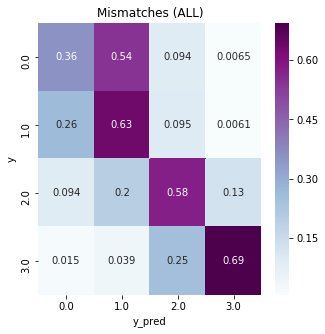

In [37]:
test_model(model=ada_model, smote=True)

f1_weighted = 0.6862115707186756
Best params = {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Accuracy = 0.18686868686868688
Balanced accuracy = 0.2979875282136644
F1 score = 0.16373696468476656


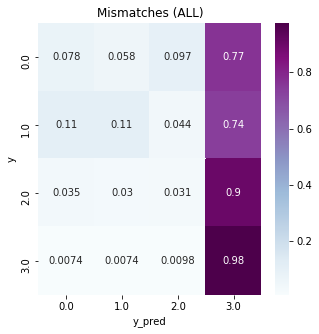

In [38]:
test_model(model=knn_model, smote=True)

f1_weighted = 0.3669052315401325
Accuracy = 0.6512493354598617
Balanced accuracy = 0.5856023882015522
F1 score = 0.6798644455552943


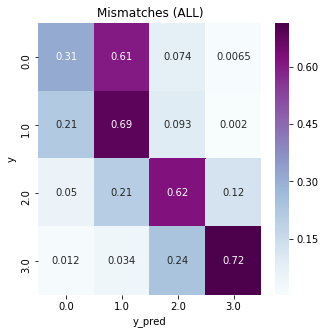

In [39]:
test_model(cat_model, smote=True)

## Different models with edited neighbours transformation (imbalanced dataset)

f1_weighted = 0.8036214448130767
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
Accuracy = 0.7139819245082403
Balanced accuracy = 0.5943005575489867
F1 score = 0.7296092177006818


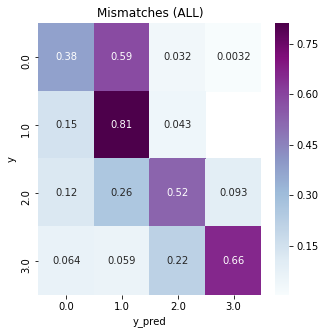

In [40]:
test_model(model=rf_model, transformation=edited_neighbours, smote=False)

f1_weighted = 0.7492139839875488
Best params = {}
Accuracy = 0.7655502392344498
Balanced accuracy = 0.5110652626940739
F1 score = 0.7268895734240982


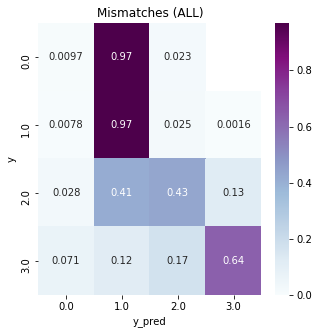

In [41]:
test_model(model=ada_model, transformation=edited_neighbours, smote=False)

f1_weighted = 0.776565369344408
Best params = {}
Accuracy = 0.7711323763955343
Balanced accuracy = 0.5274850347627046
F1 score = 0.7387976728816485


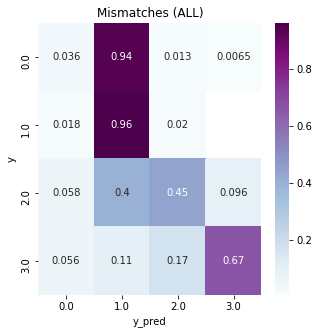

In [42]:
test_model(model=XGB_model, transformation=edited_neighbours, smote=False)

f1_weighted = 0.6640323210909412
Accuracy = 0.7698032961190856
Balanced accuracy = 0.5179430339597002
F1 score = 0.7317976097572504


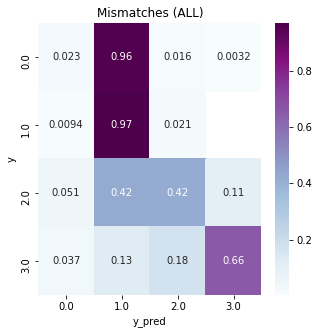

In [43]:
test_model(model=cat_model, transformation=edited_neighbours, smote=False)

### ENN transformation + SMOTE

f1_weighted = 0.5586835468567558
Best params = {}
Accuracy = 0.7575757575757576
Balanced accuracy = 0.5102182615127606
F1 score = 0.7142393529523077


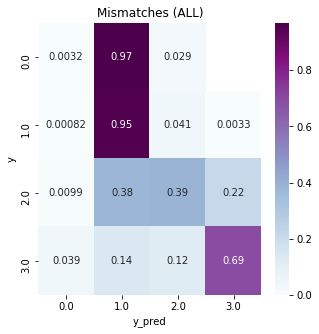

In [44]:
test_model(model=ada_model, transformation=edited_neighbours, smote=True)

f1_weighted = 0.9111013668460602
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Accuracy = 0.6975013290802764
Balanced accuracy = 0.5699723195084034
F1 score = 0.7141467368846738


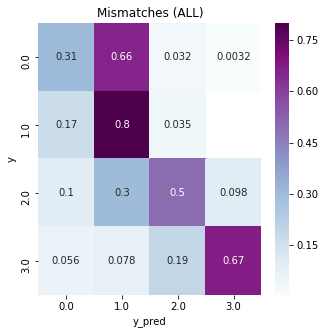

In [45]:
test_model(model=rf_model, transformation=edited_neighbours, smote=True)

f1_weighted = 0.8558054713395596
Best params = {}
Accuracy = 0.6477937267410951
Balanced accuracy = 0.5728918969785466
F1 score = 0.6855996679634756


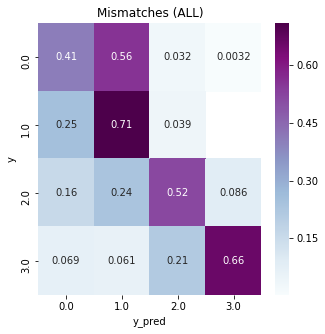

In [46]:
test_model(model=XGB_model, transformation=edited_neighbours, smote=True)

f1_weighted = 0.7408836721762816
Accuracy = 0.6321105794790005
Balanced accuracy = 0.5696342736937482
F1 score = 0.6716898845752695


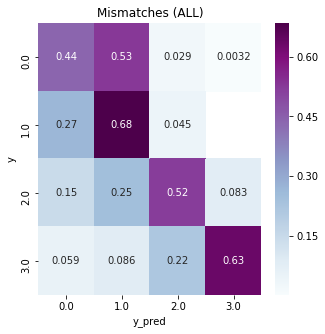

In [47]:
test_model(model=cat_model, transformation=edited_neighbours, smote=True)

## Different models with NeighbourhoodCleaningRule transformation (imbalanced dataset)

f1_weighted = 0.7941747634155397
Best params = {}
Accuracy = 0.7690058479532164
Balanced accuracy = 0.5294554320389695
F1 score = 0.7283976307704146


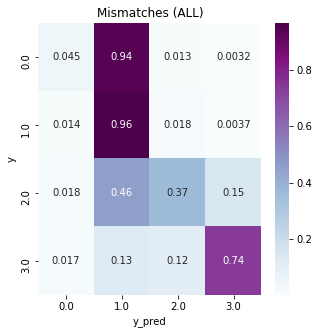

In [48]:
test_model(model=ada_model, transformation=ncr_transform, smote=False)

f1_weighted = 0.8216924700847493
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
Accuracy = 0.7570441254651781
Balanced accuracy = 0.5843413411915086
F1 score = 0.7492196153358294


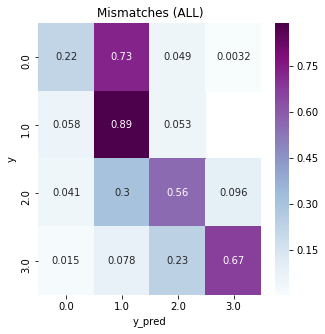

In [49]:
test_model(model=rf_model, transformation=ncr_transform, smote=False)

f1_weighted = 0.813310034986869
Best params = {}
Accuracy = 0.7841573631047315
Balanced accuracy = 0.5347262771293979
F1 score = 0.7407894336151907


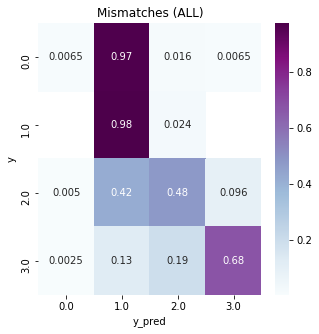

In [50]:
test_model(model=XGB_model, transformation=ncr_transform, smote=False)

f1_weighted = 0.8095283201703505
Accuracy = 0.7814992025518341
Balanced accuracy = 0.530333690975081
F1 score = 0.7368990787478488


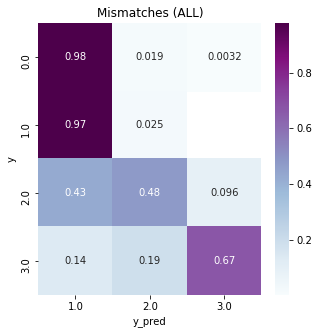

In [51]:
test_model(model=cat_model, transformation=ncr_transform, smote=False)

### NCR transformation + SMOTE

f1_weighted = 0.6829626345266613
Best params = {}
Accuracy = 0.6523125996810207
Balanced accuracy = 0.5613380059833307
F1 score = 0.6822427384590981


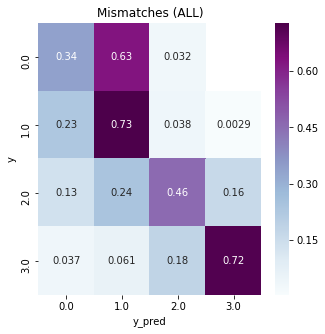

In [52]:
test_model(model=ada_model, transformation=ncr_transform, smote=True)

f1_weighted = 0.9202520507369821
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Accuracy = 0.735778841041999
Balanced accuracy = 0.5708967606959037
F1 score = 0.7338901909367698


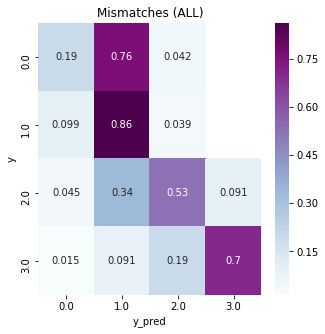

In [53]:
test_model(model=rf_model, transformation=ncr_transform, smote=True)

f1_weighted = 0.8309836077206333
Best params = {}
Accuracy = 0.6634768740031898
Balanced accuracy = 0.5754620858152012
F1 score = 0.6913749892423037


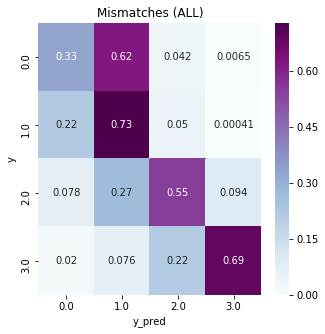

In [54]:
test_model(model=XGB_model, transformation=ncr_transform, smote=True)

f1_weighted = 0.6608925370558897
Accuracy = 0.6523125996810207
Balanced accuracy = 0.5716814565883924
F1 score = 0.6831192701261408


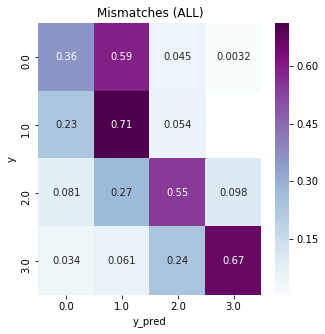

In [55]:
test_model(model=cat_model, transformation=ncr_transform, smote=True)

# Different models with Tomek transformation (imbalanced dataset)

f1_weighted = 0.7470301960879518
Best params = {}
Accuracy = 0.7812333864965444
Balanced accuracy = 0.5402604214365396
F1 score = 0.7393505420484647


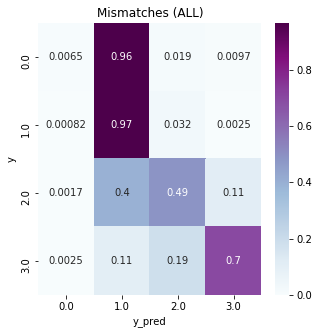

In [56]:
test_model(model=ada_model, transformation=tomek_transform, smote=False)

f1_weighted = 0.7688773296372893
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
Accuracy = 0.754120148856991
Balanced accuracy = 0.5988615913077975
F1 score = 0.7488698667006158


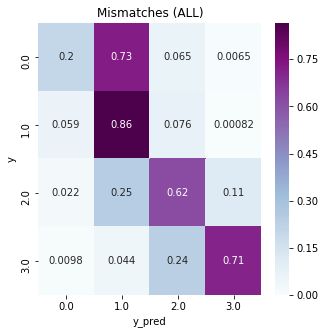

In [57]:
test_model(model=rf_model, transformation=tomek_transform, smote=False)

f1_weighted = 0.7623397413751566
Best params = {}
Accuracy = 0.7865497076023392
Balanced accuracy = 0.5415184538726463
F1 score = 0.7428656289019937


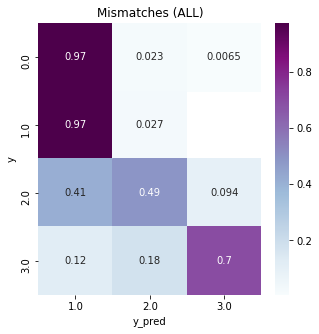

In [58]:
test_model(model=XGB_model, transformation=tomek_transform, smote=False)

f1_weighted = 0.7603105644692982
Accuracy = 0.7809675704412546
Balanced accuracy = 0.5355965617823593
F1 score = 0.7379679010151264


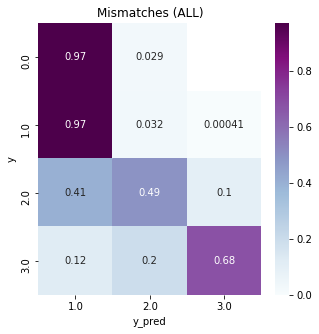

In [59]:
test_model(model=cat_model, transformation=tomek_transform, smote=False)

# Different models with Tomek transformation + SMOTE (synthetically balanced dataset)

f1_weighted = 0.6617168579577413
Best params = {}
Accuracy = 0.5778841041998937
Balanced accuracy = 0.5786835158940936
F1 score = 0.626230939233081


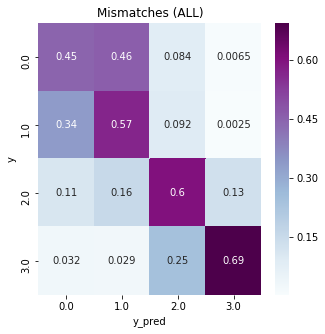

In [60]:
test_model(model=ada_model, transformation=tomek_transform, smote=True)

f1_weighted = 0.876090009482824
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Accuracy = 0.7288676236044657
Balanced accuracy = 0.5768639433625714
F1 score = 0.7285553526915172


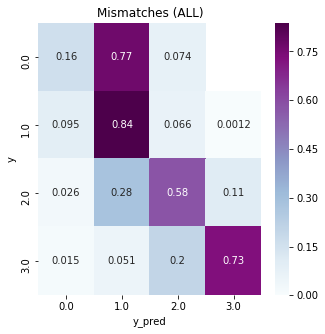

In [61]:
test_model(model=rf_model, transformation=tomek_transform, smote=True)

f1_weighted = 0.7516172485668489
Best params = {}
Accuracy = 0.6592238171185539
Balanced accuracy = 0.5896665671111447
F1 score = 0.6873777815199709


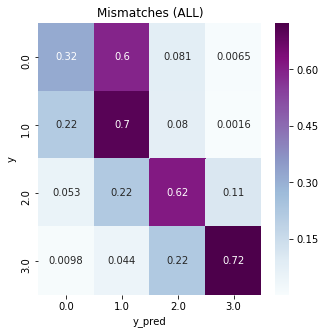

In [62]:
test_model(model=XGB_model, transformation=tomek_transform, smote=True)

f1_weighted = 0.4705634148588951
Accuracy = 0.6560340244550771
Balanced accuracy = 0.5848030264526163
F1 score = 0.6845363363332644


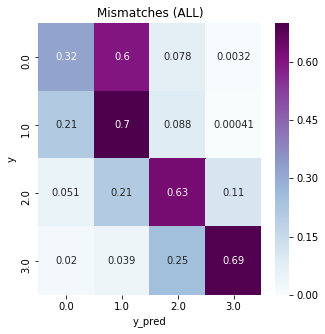

In [63]:
test_model(model=cat_model, transformation=tomek_transform, smote=True)

# Multiple random undersampling (balanced but reduced dataset several times)

## Ranfom forest

f1_weighted = 0.6305521923455031
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
f1_weighted = 0.6298053585261763
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 200}
f1_weighted = 0.6285558128929459
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
f1_weighted = 0.6231456285785543
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
f1_weighted = 0.6223632288514871
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
0.5882509303561935
0.6440984848891453
0.6340479439395632


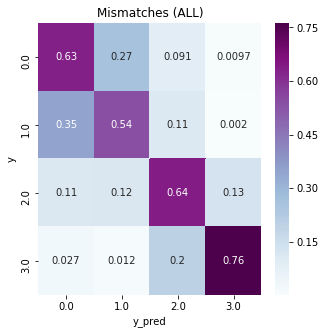

In [64]:
A=pd.DataFrame()

for i in range(5):
    X1, y1 = undersampling(X_train, y_train)
    clf = rf_model(X1, y1)
    y_pred = clf.predict(X_test)
    A[i] = y_pred
    
y_pred = A.mode(axis=1)[0]
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

mm_input = pd.DataFrame()
mm_input['y'] = y_test
mm_input['y_pred'] = y_pred
edges = mm_input.groupby('y')['y_pred'].value_counts()
m = pd.DataFrame(edges.unstack(level=-1))
m = m.div(m.sum(axis=1), axis=0)
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Mismatches (ALL)')
sns.heatmap(m, annot=True,cmap='BuPu')
plt.show()

## XGBoost

f1_weighted = 0.6285219036675929
Best params = {}
f1_weighted = 0.6301972906236649
Best params = {}
f1_weighted = 0.6262890374336649
Best params = {}
f1_weighted = 0.6297850644163253
Best params = {}
f1_weighted = 0.632645914472744
Best params = {}
f1_weighted = 0.6272714007101803
Best params = {}
f1_weighted = 0.6276245137755682
Best params = {}
f1_weighted = 0.6291653327915869
Best params = {}
f1_weighted = 0.6271120265479152
Best params = {}
f1_weighted = 0.6309881782767084
Best params = {}
f1_weighted = 0.6255289974416888
Best params = {}
f1_weighted = 0.629578820042196
Best params = {}
f1_weighted = 0.6275680796148868
Best params = {}
f1_weighted = 0.6271923719453817
Best params = {}
f1_weighted = 0.629666956505973
Best params = {}
f1_weighted = 0.621959266176385
Best params = {}
f1_weighted = 0.623567416970192
Best params = {}
f1_weighted = 0.6340317627601925
Best params = {}
f1_weighted = 0.6281890580027384
Best params = {}
f1_weighted = 0.6311576920823817
Best params = {}
0.585

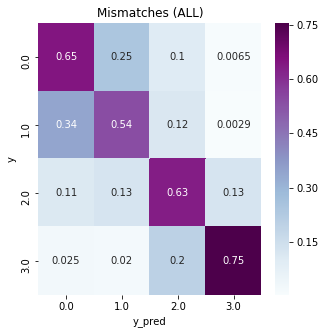

In [65]:
A=pd.DataFrame()
for i in range(20):
    X1, y1 = undersampling(X_train, y_train)
    clf = XGB_model(X1, y1)
    y_pred = clf.predict(X_test)
    A[i] = y_pred
    
y_pred = A.mode(axis=1)[0]
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

mm_input = pd.DataFrame()
mm_input['y'] = y_test
mm_input['y_pred'] = y_pred

edges = mm_input.groupby('y')['y_pred'].value_counts()
m = pd.DataFrame(edges.unstack(level=-1))
m = m.div(m.sum(axis=1), axis=0)
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Mismatches (ALL)')
sns.heatmap(m, annot=True,cmap='BuPu')
plt.show()

## AdaBoost

f1_weighted = 0.5755232340247699
Best params = {}
f1_weighted = 0.5798459422086618
Best params = {}
f1_weighted = 0.5813332058093348
Best params = {}
f1_weighted = 0.5880805708725189
Best params = {}
f1_weighted = 0.5867736408744856
Best params = {}
f1_weighted = 0.5918290937146633
Best params = {}
f1_weighted = 0.5797940373975471
Best params = {}
f1_weighted = 0.5811116839063689
Best params = {}
f1_weighted = 0.5844829419488438
Best params = {}
f1_weighted = 0.5803514323481923
Best params = {}
f1_weighted = 0.5833013821172858
Best params = {}
f1_weighted = 0.5553532594691846
Best params = {}
f1_weighted = 0.5838660928780773
Best params = {}
f1_weighted = 0.5824192722163938
Best params = {}
f1_weighted = 0.5752738395554586
Best params = {}
f1_weighted = 0.5825530946890399
Best params = {}
f1_weighted = 0.5686032528855258
Best params = {}
f1_weighted = 0.5793857382030034
Best params = {}
f1_weighted = 0.5804751215762873
Best params = {}
f1_weighted = 0.5822427913524455
Best params = {}


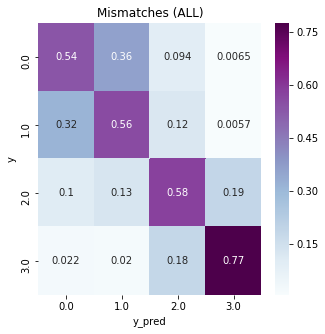

In [66]:
A = pd.DataFrame()

for i in range(20):
    X1, y1 = undersampling(X_train, y_train)
    clf = ada_model(X1, y1)
    y_pred = clf.predict(X_test)
    A[i] = y_pred
    
y_pred = A.mode(axis=1)[0]
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

mm_input = pd.DataFrame()
mm_input['y'] = y_test
mm_input['y_pred'] = y_pred

edges = mm_input.groupby('y')['y_pred'].value_counts()
m = pd.DataFrame(edges.unstack(level=-1))
m = m.div(m.sum(axis=1), axis=0)
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Mismatches (ALL)')
sns.heatmap(m, annot=True,cmap='BuPu')
plt.show()



# Different models with Tomek transformation + multiple random undersampling (balanced but reduced dataset several times)

## Ranfom forest

f1_weighted = 0.6631934797625828
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
f1_weighted = 0.6643293802354024
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 200}
f1_weighted = 0.6622546376974381
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
f1_weighted = 0.6667611484979576
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
f1_weighted = 0.6685835365415703
Best params = {'classifier__criterion': 'gini', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
0.5903774587985114
0.6406023276534508
0.6373502260197451


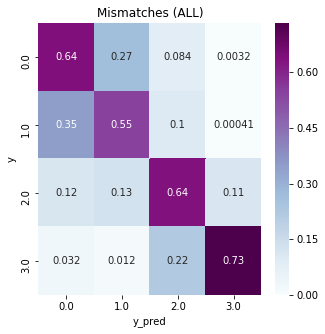

In [69]:
A=pd.DataFrame()

for i in range(5):
    X1, y1 = undersampling(
        tomek_transform(X_train, y_train)[0], 
        tomek_transform(X_train, y_train)[1]
    )
    clf = rf_model(X1, y1)
    y_pred = clf.predict(X_test)
    A[i] = y_pred
    
y_pred = A.mode(axis=1)[0]
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

mm_input = pd.DataFrame()
mm_input['y'] = y_test
mm_input['y_pred'] = y_pred
edges = mm_input.groupby('y')['y_pred'].value_counts()
m = pd.DataFrame(edges.unstack(level=-1))
m = m.div(m.sum(axis=1), axis=0)
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Mismatches (ALL)')
sns.heatmap(m, annot=True,cmap='BuPu')
plt.show()

## XGBoost

f1_weighted = 0.6648478641722042
Best params = {}
f1_weighted = 0.6702049774904332
Best params = {}
f1_weighted = 0.6646246740510596
Best params = {}
f1_weighted = 0.6572365762097244
Best params = {}
f1_weighted = 0.6613739536814458
Best params = {}
f1_weighted = 0.6667076783211928
Best params = {}
f1_weighted = 0.6666251732097876
Best params = {}
f1_weighted = 0.6656429086630177
Best params = {}
f1_weighted = 0.6617897253318977
Best params = {}
f1_weighted = 0.663804823206438
Best params = {}
f1_weighted = 0.6627459467608443
Best params = {}
f1_weighted = 0.6636567729834543
Best params = {}
f1_weighted = 0.6639534132482479
Best params = {}
f1_weighted = 0.6632900379404932
Best params = {}
f1_weighted = 0.6608902954103364
Best params = {}
f1_weighted = 0.6624510540440742
Best params = {}
f1_weighted = 0.6684245631020922
Best params = {}
f1_weighted = 0.6660251896580596
Best params = {}
f1_weighted = 0.6640032651295202
Best params = {}
f1_weighted = 0.6665846976287098
Best params = {}
0

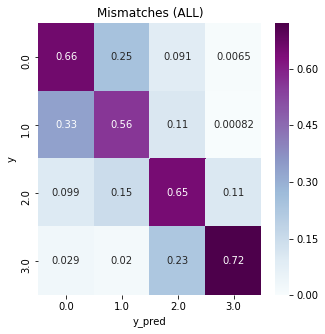

In [70]:
A=pd.DataFrame()
for i in range(20):
    X1, y1 = undersampling(
        tomek_transform(X_train, y_train)[0],
        tomek_transform(X_train, y_train)[1])
    clf = XGB_model(X1, y1)
    y_pred = clf.predict(X_test)
    A[i] = y_pred
y_pred = A.mode(axis=1)[0]
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

mm_input = pd.DataFrame()
mm_input['y'] = y_test
mm_input['y_pred'] = y_pred

edges = mm_input.groupby('y')['y_pred'].value_counts()
m = pd.DataFrame(edges.unstack(level=-1))
m = m.div(m.sum(axis=1), axis=0)
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Mismatches (ALL)')
sns.heatmap(m, annot=True,cmap='BuPu')
plt.show()

## AdaBoost

f1_weighted = 0.6053603858763295
Best params = {}
f1_weighted = 0.6064479757780743
Best params = {}
f1_weighted = 0.6168364765528943
Best params = {}
f1_weighted = 0.6083413910313942
Best params = {}
f1_weighted = 0.618821072648156
Best params = {}
f1_weighted = 0.6116482462649384
Best params = {}
f1_weighted = 0.6088172515104876
Best params = {}
f1_weighted = 0.6170693296365021
Best params = {}
f1_weighted = 0.6101603647587248
Best params = {}
f1_weighted = 0.6121196026007657
Best params = {}
f1_weighted = 0.6132526232372366
Best params = {}
f1_weighted = 0.6176460214042072
Best params = {}
f1_weighted = 0.6142589916868998
Best params = {}
f1_weighted = 0.6108076479590712
Best params = {}
f1_weighted = 0.6096524746262583
Best params = {}
f1_weighted = 0.615437768134468
Best params = {}
f1_weighted = 0.6194080971392858
Best params = {}
f1_weighted = 0.6016137221550393
Best params = {}
f1_weighted = 0.5902618901772326
Best params = {}
f1_weighted = 0.6142610628762177
Best params = {}
0.

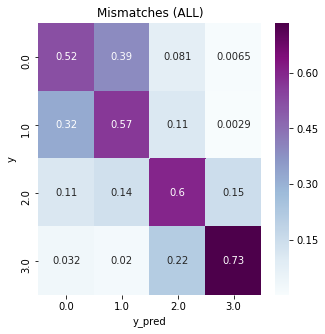

In [71]:
A = pd.DataFrame()

for i in range(20):
    X1, y1 = undersampling(
        tomek_transform(X_train, y_train)[0],
        tomek_transform(X_train, y_train)[1])
    clf = ada_model(X1, y1)
    y_pred = clf.predict(X_test)
    A[i] = y_pred
y_pred = A.mode(axis=1)[0]
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='weighted'))

mm_input = pd.DataFrame()
mm_input['y'] = y_test
mm_input['y_pred'] = y_pred

edges = mm_input.groupby('y')['y_pred'].value_counts()
m = pd.DataFrame(edges.unstack(level=-1))
m = m.div(m.sum(axis=1), axis=0)
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title('Mismatches (ALL)')
sns.heatmap(m, annot=True,cmap='BuPu')
plt.show()


# Redefining classification task

Merge Seed and Series A in one class, Series B and Growth in the other to classify early and late stages.

In [82]:
def get_train_data(data):
    
    data = data[data.investment_type > 0]
    data.investment_type.replace(1, 0, inplace=True)
    data.investment_type.replace(2, 0, inplace=True)
    data.investment_type.replace(3, 1, inplace=True)
    data.investment_type.replace(4, 1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=data.investment_type.map({
        0:'Early stage', 
        1:'Late stage'
    }).value_counts(dropna=False).index,
                     y=data.investment_type.value_counts(dropna=False),
                     palette='BuPu')
    plt.ylabel('Value counts', fontsize=12)
    plt.xlabel('Deal stage', fontsize=12)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig('demo1.png', transparent=True)
    
    y = data.investment_type.values
    X = data.drop(['investment_type', 'company_name_x', 'domain'], axis=1)

    return X, y

New functions for binary classification problem.

In [83]:
def balancedrf_model(X_train, y_train):

    params={'classifier__n_estimators':[200],
            'classifier__criterion':['gini','entropy'],
            'classifier__min_samples_leaf':[3,5,7]}

    pipe = Pipeline([
                ('classifier', BalancedRandomForestClassifier())
                ])

    clf = GridSearchCV(pipe, params, cv = 5, scoring='f1')
    clf.fit(X_train,y_train)

    print('f1 =', clf.best_score_)
    print('Best params =', clf.best_params_)
    
    return clf.best_estimator_

In [84]:
def cat_model(X_train, y_train):
    
    params = {
         #'depth': [4, 6, 8],
         #'l2_leaf_reg': [1,3,5],
         'iterations': [200]
         }
    cb = CatBoostClassifier(logging_level='Silent')
    cb_model = GridSearchCV(cb, params, cv = 5, scoring='f1')
    cb_model.fit(X_train, y_train, cat_features=[X_train.columns.get_loc(x) for x in X_train.columns if x not in nums])
    print('f1 =', cb_model.best_score_)
    
    return cb_model.best_estimator_

In [85]:
def test_model(model, transformation=None, smote=False, X=X_train, y=y_train, X_t=X_test, y_t=y_test):
    
    if transformation is None:
        X1, y1 = X, y
    else:
        X1, y1 = transformation(X, y)
    if smote is True:
        X1, y1 = smote_transform(X1, y1)
    clf = model(X1, y1)
    y_pred = clf.predict(X_t)
    
    print('Accuracy =', accuracy_score(y_t, y_pred))
    print('Balanced accuracy =', balanced_accuracy_score(y_t, y_pred))
    print('F1 score =', f1_score(y_t, y_pred))
    
    mm_input = pd.DataFrame()
    mm_input['y'] = y_t
    mm_input['y_pred'] = y_pred

    edges = mm_input.groupby('y')['y_pred'].value_counts()
    m = pd.DataFrame(edges.unstack(level=-1))
    m = m.div(m.sum(axis=1), axis=0)
    a4_dims = (5, 5)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.title('Mismatches (ALL)')
    sns.heatmap(m, annot=True,cmap='BuPu')
    plt.show()

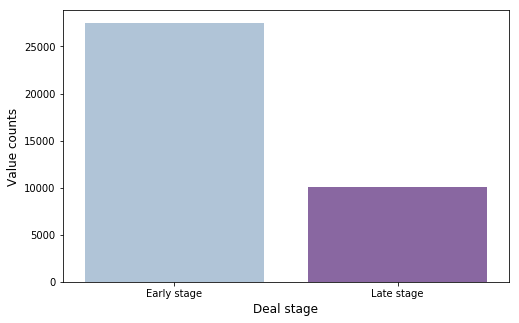

In [86]:
X, y = get_train_data(df)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.1, 
                                                    stratify=y,
                                                    random_state=241)

f1 = 0.800656520126918
Best params = {'classifier__criterion': 'entropy', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 200}
Accuracy = 0.8904837852206273
Balanced accuracy = 0.8782529644268775
F1 score = 0.8071161048689138


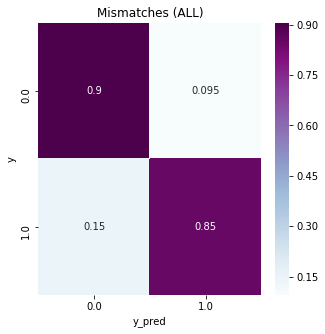

In [88]:
test_model(balancedrf_model)

f1 = 0.8057907371329954
Accuracy = 0.9074960127591707
Balanced accuracy = 0.8614743083003953
F1 score = 0.815873015873016


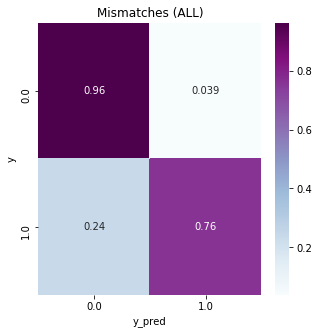

In [89]:
test_model(cat_model)